# Experiments Notebook 1


In [ ]:
!pip install pydot

In [23]:
!pip install keras-hypetune

     |████████████████████████████████| 965 kB 2.3 MB/s            
     |████████████████████████████████| 1.9 MB 162.9 MB/s            
     |████████████████████████████████| 76 kB 5.5 MB/s              
     |████████████████████████████████| 829 kB 133.3 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=acf2ac9c02201496004406e2a1770287b854d858ae8943b3cfe4659a34ee7588
  Stored in directory: /home/noah/.cache/pip/wheels/2f/a0/d3/4030d9f80e6b3be787f19fc911b8e7aa462986a40ab1e4bb94
Successfully built future
You should consider upgrading via the '/home/noah/projects/drexel/dsci592/DS-capstone-pt1/env/bin/python -m pip install --upgrade pip' command.


In [ ]:
!

In [35]:
import os
import os.path
import pickle
import bz2
from glob import glob
import random
import shutil
from datetime import datetime

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from kerashypetune import KerasGridSearch

In [2]:
pd.set_option("display.max_columns", None)

### Load the golden data

In [ ]:
# Windows version
golden_dataset_file_name = os.path.join('..', '..', 'data', 'golden', 'feeFiFoFum.pbz2')

# data = bz2.BZ2File(golden_dataset_file_name,'rb')
with bz2.BZ2File(golden_dataset_file_name,'rb') as data:
    df = pd.read_pickle(data)
df

In [3]:
# Linux version (problems with bz2 file)

golden_dataset_file_name = os.path.join('/', 'data', 'projects', 'drexel', 'dsci592', 'feeFiFoFum.pkl')

df = pd.read_pickle(golden_dataset_file_name)
df

,dates,JHU_ConfirmedCases.data,NYT_ConfirmedCases.data,JHU_ConfirmedDeaths.data,NYT_ConfirmedDeaths.data,NYT_ConfirmedDeaths.missing,TotalPopulation.data,MaleAndFemale_AtLeast65_Population.data,Male_Total_Population.data,Female_Total_Population.data,MaleAndFemale_Under18_Population.data,BLS_EmployedPopulation.data,BLS_EmployedPopulation.missing,BLS_UnemployedPopulation.data,BLS_UnemployedPopulation.missing,BLS_UnemploymentRate.data,BLS_UnemploymentRate.missing,BLS_LaborForcePopulation.data,BLS_LaborForcePopulation.missing,AverageDailyTemperature.data,AverageDailyTemperature.missing,AverageDewPoint.data,AverageDewPoint.missing,AverageRelativeHumidity.data,AverageRelativeHumidity.missing,AverageSurfaceAirPressure.data,AverageSurfaceAirPressure.missing,AveragePrecipitationTotal.data,AveragePrecipitationTotal.missing,AveragePrecipitation.data,AveragePrecipitation.missing,AverageWindDirection.data,AverageWindDirection.missing,AverageWindSpeed.data,AverageWindSpeed.missing,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,fips,county,jhu_daily_death,jhu_daily_cases,jhu_daily_new_cases,jhu_daily_death_rolling_7,jhu_daily_cases_rolling_7,jhu_daily_new_cases_rolling_7,jhu_daily_death_rolling_30,jhu_daily_cases_rolling_30,jhu_daily_new_cases_rolling_30,LND110210,jhu_death_rate,jhu_case_rate,jhu_new_case_rate,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,cold_days,hot_days,moderate_days,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent,totalMoved,movedWithinState,movedWithoutState,movedFromAbroad,publicTrans,totalTrans,householdsTotal,houseWith65,house2+with65,houseFamily65,houseNonfam65,houseNo65,house2+No65,houseFamilyNo65,houseNonfamNo65,householdStructuresTotal,householdIncomeMedian,gini,hoursWorkedMean,unitsInStructure,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,countyStateName,stateFip,countyFip,pm25
0,2020-03-19,1.0,1.0,0.0,0.0,0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,386.5,0.0,3.825596,0.0,10103.0,0.0,68.659722,0.0,63.152778,0.0,84.152778,0.0,29.590139,0.0,0.000833,0.0,0.000000,0.0,192.326389,0.0,6.732639,0.0,6.0,25.0,25.0,24527.0,45001,Abbeville_SouthCarolina_UnitedStates,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,490.48,0.0,0.000000,0.000000,50.006116,0.000245,0.001019,0.001019,0,0,1,0.217842,0.200758,0.961744,0.038256,24317.0,1118.0,329.0,12.0,44,9791,9660,3645,2081,2042,39,6015,4531,4206,325,9660,38741,0.4790,38.1,12191,24397,21415,179,87,39,122,2555,"Abbeville County, South Carolina",45,001,9.618551
1,2020-03-20,1.0,1.0,0.0,0.0,0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,386.5,0.0,3.825596,0.0,10103.0,0.0,72.541667,0.0,60.583333,0.0,68.708333,0.0,29.537708,0.0,0.000000,0.0,0.000000,0.0,208.125000,0.0,10.833333,0.0,6.0,25.0,25.0,24527.0,45001,Abbeville_SouthCarolina_UnitedStates,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,490.48,0.0,0.000000,0.000000,50.006116,0.000245,0.001019,0.001019,0,0,1,0.217842,0.200758,0.961744,0.038256,24317.0,1118.0,329.0,12.0,44,9791,9660,3645,2081,2042,39,6015,4531,4206,325,9660,38741,0.4790,38.1,12191,24397,21415,179,87,39,122,2555,"Abbeville County, South Carolina",45,001,9.618551
2,2020-03-21,1.0,1.0,0.0,0.0,0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,386.5,0.0,3.825596,0.0,10103.0,0.0,69.208333,0.0,56.708333,0.0,66.583333,0.0,29.520417,0.0,0.000000,0.0,0.000000,0.0,252.916667,0.0,8.125000,0.0,6.0,25.0,25.0,24527.0,45001,Abbeville_SouthCarolina_UnitedStates,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,490.48,0.0,0.000000,0.000000,50.006116,0.000245,0.001019,0.001019,0,0,1,0.217842,0.200758,0.961744,0.038256,24317.0,1118.0,329.0,12.0,44,9791,9660,3645,2081,2042,39,6015,4531,4206,325,9660,38741,0.4790,38.1,12191,24397,21415,179,87,39,122,2555,"Abbeville County, South Carolina",45,001,9.618551
3,2020-03-22,1.0,1.0,0.0,0.0,0,24527.0,5343.0,11868.

### Clean up the data

#### Drop non-numeric and unnecessary columns

In [4]:
cols = ['NYT_ConfirmedCases.data','NYT_ConfirmedDeaths.data','NYT_ConfirmedDeaths.missing','county','LND110210','countyStateName','stateFip','countyFip']

df.drop(cols, axis=1, inplace=True)

#### Temporarily, replace FIPS codes with latitude and longitude of the centroid of each county

In [5]:
counties = pd.read_csv('2021_Gaz_counties_national.txt', delimiter='\t')
counties.rename(columns={'INTPTLONG                                                                                                               ': 'INTPTLONG'}, inplace=True)

In [6]:
counties = counties[['GEOID', 'INTPTLAT', 'INTPTLONG' ]]
df.fips = df.fips.astype('int64')

df = df.merge(counties, how='left', left_on='fips', right_on='GEOID')
df.drop(['GEOID'], axis=1, inplace=True)

#### Replace dates with monotonically increasing integers starting with the minimum date

In [7]:
df.dates = pd.to_datetime(df.dates, format='%Y-%m-%d')
min_date = min(df.dates)
max_date = max(df.dates)
min_date, max_date, df.dates.dtype

(Timestamp('2020-03-11 00:00:00'),
 Timestamp('2022-01-16 00:00:00'),
 dtype('<M8[ns]'))

In [8]:
df['day'] =(df.dates - min_date).dt.days
df.drop(['dates'], axis=1, inplace=True)

#### Replace the integer representation of date with sin and cosine encoding

In [9]:
cyclical_interval = 365
continuous_interval = 3650
df['cyclical_sin'] = np.sin((df.day * 2 * np.pi)/cyclical_interval)
df['cyclical_cos'] = np.cos((df.day * 2 * np.pi)/cyclical_interval)
df['continuous_sin'] = np.sin((df.day * 2 * np.pi)/continuous_interval)
df['continuous_cos'] = np.cos((df.day * 2 * np.pi)/continuous_interval)
df.drop('day', axis=1, inplace=True)

#### Normalize the data

In [10]:
cols_to_normalize = [
       'TotalPopulation.data', 'MaleAndFemale_AtLeast65_Population.data',
       'Male_Total_Population.data', 'Female_Total_Population.data',
       'MaleAndFemale_Under18_Population.data', 'BLS_EmployedPopulation.data',
       'BLS_EmployedPopulation.missing', 'BLS_UnemployedPopulation.data',
       'BLS_UnemployedPopulation.missing', 'BLS_UnemploymentRate.data',
       'BLS_UnemploymentRate.missing', 'BLS_LaborForcePopulation.data',
       'BLS_LaborForcePopulation.missing', 'AverageDailyTemperature.data',
       'AverageDailyTemperature.missing', 'AverageDewPoint.data',
       'AverageDewPoint.missing', 'AverageRelativeHumidity.data',
       'AverageRelativeHumidity.missing', 'AverageSurfaceAirPressure.data',
       'AverageSurfaceAirPressure.missing', 'AveragePrecipitationTotal.data',
       'AveragePrecipitationTotal.missing', 'AveragePrecipitation.data',
       'AveragePrecipitation.missing', 'AverageWindDirection.data',
       'AverageWindDirection.missing', 'AverageWindSpeed.data',
       'AverageWindSpeed.missing', 'hospitalIcuBeds', 'hospitalStaffedBeds',
       'hospitalLicensedBeds', 'latestTotalPopulation', 'jhu_daily_death',
       'jhu_daily_cases', 'jhu_daily_new_cases', 
    'jhu_daily_death_rolling_7',
       'jhu_daily_cases_rolling_7', 'jhu_daily_new_cases_rolling_7',
       'jhu_daily_death_rolling_30', 'jhu_daily_cases_rolling_30',
       'jhu_daily_new_cases_rolling_30', 'jhu_death_rate', 'jhu_case_rate',
       'jhu_new_case_rate', 'density', 'icu_beds_per_person',
       'staffed_beds_per_person', 'licensed_beds_per_person', 'cold_days',
       'hot_days', 'moderate_days', 'gte_65_percent', 'lt_18_percent',
       'employed_percent', 'unemployed_percent', 'totalMoved',
       'movedWithinState', 'movedWithoutState', 'movedFromAbroad',
       'publicTrans', 'totalTrans', 'householdsTotal', 'houseWith65',
       'house2+with65', 'houseFamily65', 'houseNonfam65', 'houseNo65',
       'house2+No65', 'houseFamilyNo65', 'houseNonfamNo65',
       'householdStructuresTotal', 'householdIncomeMedian', 'gini',
       'hoursWorkedMean', 'unitsInStructure', 'healthInsTotal',
       'healthInsNativeWith', 'healthInsForeignNatWith',
       'healthInsForeignNoncitWith', 'healthInsForeignNatNo',
       'healthInsForeignNoncitNo', 'healthInsNativeNo', 'pm25', 'INTPTLAT',
       'INTPTLONG']
cols_raw = ['fips','JHU_ConfirmedCases.data', 'JHU_ConfirmedDeaths.data', 'cyclical_sin', 'cyclical_cos', 'continuous_sin',
       'continuous_cos']
df_normalized = df[cols_to_normalize]
df_normalized = (df_normalized - df_normalized.mean())/df_normalized.std()
df_raw = df[cols_raw]
df = pd.concat([df_raw, df_normalized], axis=1)


#### Prepare the data for training

In [11]:
days_of_history = 30
days_to_predict = 1

In [12]:
fips = df.fips.unique()

def x_generator(data, days_of_history=30, days_to_predict=1):
    for j, fip in enumerate(fips):
        if not j % 100: print(j, end=' ')
        county = data[data.fips == fip]
        for i in range(days_of_history, len(county) - days_to_predict):
            data_matrix = data.iloc[i - days_of_history: i, 1:].to_numpy()
            yield data_matrix
            
def y_generator(data, days_of_history=30, days_to_predict=1):
    for fip in fips:
        county = data[data.fips == fip]
        for i in range(days_of_history, len(county) - days_to_predict):
            data_matrix = data.iloc[i: i + days_to_predict, 1:3].to_numpy()
            yield data_matrix
    
def xy_generator(data, days=31):
    for j, fip in enumerate(fips):
        if not j % 100: print(j, end=' ')
        county = data[data.fips == fip]
        for i in range(days, len(county) + 1):
            data_matrix = data.iloc[i - days: i, 1:].to_numpy()
            yield data_matrix
            
        
            
    

##### Save the raw X and Y to files of 50,000 sequences

In [ ]:
Xi = []
j = 0

N_SAMPLES = 2

for i, x in enumerate(xy_generator(df)):
    Xi.append(x)
    if i and not i % (N_SAMPLES - 1):
        X = np.asarray(Xi)
        np.savez(os.path.join('.','data', f'x_{j}.np'), X)
        j += 1
        Xi = []
if Xi:
    X = np.asarray(Xi)
    np.savez(os.path.join('.','data', f'x_{j}.npz'), X)
 



##### Split into train, test, eval directories

In [35]:
x_files = glob('./data/x_*.npz')
random.shuffle(x_files)
n_files = len(x_files)
print(n_files)
n_train = int(n_files * 0.70)
print(n_train)
n_eval = int(n_files * 0.15)
print(n_eval)
n_test = n_files - n_train - n_eval
print(n_test)
train_files = x_files[:n_train]
# print(len(train_files))
eval_files = x_files[n_train:n_train+n_test]
# print(len(eval_files))
test_files = x_files[n_train+n_test:]
assert n_files == len(train_files) + len(eval_files) + len(test_files)
for (subdir, lst) in [['train', train_files], ['eval', eval_files], ['test', test_files]]:
    for file in lst:
        shutil.move(file, os.path.join('.', 'data', subdir))
        

8981
6286
1347
1348


##### Create the Tensorflow Dataset

In [ ]:
train_files = glob('./data/train/x_*.npz')
eval_files = glob('./data/eval/x_*.npz')
test_files = glob('./data/test/x_*.npz')

n_readers = 5
n_parse_threads = 5
len_array = 995

def create_generator(files, cycle_length=5):
    random.shuffle(files)
    for i in range(0, len(files), cycle_length):
        subset = files[i:i+cycle_length]
        np_arrays = [np.load(s)['arr_0'] for s in subset]
        np_array = np.concatenate(np_arrays, axis=0)
        if np_array.shape[0] != len_array:
            continue
        np.random.shuffle(np_array)
        yield np_array        
            

def split_xy(np_array):
    # seq_len = np_array.shape[1]
    X = np_array[:,:-1,:]
    y = np_array[:,-1:,:1]
    return X,y
        
    
def get_dataset_size():
    size = 0
    for file in x_files:
        x = np.load(file)['arr_0']
        if x.shape[0] != 199:
            continue
        # print(x.shape)
        # break
        size += x.shape[0]
    return size


def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000, seed=None):
    """ Adapted from https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438"""
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=seed)
    
    train_size = int(train_split * ds_size)
    print('Train size:', train_size)
    val_size = int(val_split * ds_size)
    print('Val size:', val_size)
    print('Test size:', ds_size - train_size - val_size)
    
    BATCH_SIZE = 4096
    train_ds = ds.take(train_size).prefetch(1)    
    val_ds = ds.skip(train_size).take(val_size).prefetch(1)
    test_ds = ds.skip(train_size).skip(val_size).prefetch(1)
    
    return train_ds, val_ds, test_ds    
    
    
train_ds = tf.data.Dataset.from_generator(lambda: create_generator(train_files, cycle_length=n_readers), output_types=tf.float32 )
train_ds = train_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

val_ds = tf.data.Dataset.from_generator(lambda: create_generator(eval_files, cycle_length=n_readers), output_types=tf.float32 )
val_ds = val_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

test_ds = tf.data.Dataset.from_generator(lambda: create_generator(test_files, cycle_length=n_readers), output_types=tf.float32 )
test_ds = test_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)


## Building the model

In [51]:
param_grid = {
    'recurrent_layer_type': [keras.layers.LSTM, keras.layers.GRU],
    'n_recurrent': [1, 2, 3],
    'unit': [32, 64, 128],
    'include_dropout': [False, True],
    'dropout': [0.10, 0.20],
    'lr': [1e-2, 1e-3],   
    'epochs': 256,
}

In [55]:
def build_model(param, shape=(30,92)):
    input = keras.layers.Input(shape=shape)
    last = input
    for i in range(param['n_recurrent']):
        last = param['recurrent_layer_type'](param['unit'])(last)
        if param['include_dropout']:
            last = keras.layers.Dropout(param['dropout'])(last)
    output = keras.layers.Dense(1)(last)
    model = keras.models.Model(inputs=input, outputs=output)
    model.compile(optimizer = Adam(learning_rate=param['lr']),  loss='mae',  metrics=['mse', 'mae'])
        
    return model


                      

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mae', patience=10, restore_best_weights=True)

n_trial = 3

name = f'trial_{n_trial}'
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

checkpoint_cb = keras.callbacks.ModelCheckpoint(f'./data/model/{name}_{timestamp}.h5', save_best_only=True)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs/{}".format(name))


hypermodel = lambda param: build_model(param=param)

kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(train_ds, validation_data=val_ds, callbacks=[early_stopping_cb, checkpoint_cb, tensorboard], shuffle=False)



144 trials detected for ('recurrent_layer_type', 'n_recurrent', 'unit', 'include_dropout', 'dropout', 'lr', 'epochs')

***** (1/144) *****
Search({'recurrent_layer_type': <class 'keras.layers.recurrent_v2.LSTM'>, 'n_recurrent': 1, 'unit': 32, 'include_dropout': False, 'dropout': 0.1, 'lr': 0.01, 'epochs': 256})


# IGNORE BELOW

In [14]:
# Complex model

input = keras.layers.Input(shape=(30,92))
lstm1 = keras.layers.LSTM(512, return_sequences=True)(input)
dropout1 = keras.layers.Dropout(0.20)(lstm1)
lstm2 = keras.layers.LSTM(512, return_sequences=True)(dropout1)
dropout2 = keras.layers.Dropout(0.20)(lstm2)
lstm3 = keras.layers.LSTM(512, return_sequences=True)(dropout2)
dropout3 = keras.layers.Dropout(0.20)(lstm3)
lstm4 = keras.layers.LSTM(512, return_sequences=True)(dropout3)
dropout4 = keras.layers.Dropout(0.20)(lstm4)
lstm5 = keras.layers.LSTM(512)(dropout4)
output = keras.layers.Dense(1)(lstm5)
model = keras.models.Model(inputs=input, outputs=output)

In [15]:
# Simple model for quick testing

input = keras.layers.Input(shape=(30,92))
lstm1 = keras.layers.LSTM(32, return_sequences=True)(input)
output = keras.layers.Dense(1)(lstm1)
model = keras.models.Model(inputs=input, outputs=output)

In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 92)]          0         
                                                                 
 lstm_5 (LSTM)               (None, 30, 32)            16000     
                                                                 
 dense_1 (Dense)             (None, 30, 1)             33        
                                                                 
Total params: 16,033
Trainable params: 16,033
Non-trainable params: 0
_________________________________________________________________


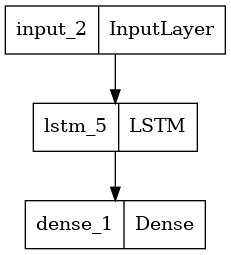

In [17]:
# keras.utils.plot_model(model, to_file='multilayer_perceptron_graph.png')
keras.utils.plot_model(model)


In [21]:
model.compile(optimizer = 'adam',  loss='mae',  metrics=['mse', 'mae'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./data/model/covid_lstm.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mae', patience=10, restore_best_weights=True)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs/{}".format(NAME))
history = model.fit(train_ds, epochs=1024, 
                    validation_data=val_ds, 
                    callbacks=[checkpoint_cb, early_stopping_cb,v]
                   )

NameError: name 'NAME' is not defined

In [ ]:
# I added this to the data preprocessing, so not required

class TimeEncoding(keras.layers.Layer):
    """ Layer to encode cyclical and continuous time.  
    Input should an n x 1 array or vector of integers.  
    Integers represent number of time units (i.e., days) from the starting point"""

    def __init__(self, cyclical_interval=365, continuous_interval=3650 , **kwargs):
        self.cyclical_interval = cyclical_interval
        self.continuous_interval = continuous_interval
        super(TimeEncoding, self).__init__(**kwargs)

    def call(self, x):
        
        cyclical_sin = np.sin((x * 2 * np.pi)/self.cyclical_interval)
        cyclical_cos = np.cos((x * 2 * np.pi)/self.cyclical_interval)
        continuous_sin = np.sin((x * 2 * np.pi)/self.continuous_interval)
        continuous_cos = np.cos((x * 2 * np.pi)/self.continuous_interval)
        
        return keras.layers.concatenate([cyclical_sin, cyclical_cos, continuous_sin, continuous_cos], axis=1)
        

In [ ]:
time_encoding = TimeEncoding()
x = np.arange(30)/1.0
x = x[:, tf.newaxis]
time_encoding(x)

input = keras.layers.Input(shape=(30,92))
lstm1 = keras.layers.LSTM(512, return_sequences=True)(input)
dropout1 = keras.layers.Dropout(0.20)(lstm1)
lstm2 = keras.layers.LSTM(512, return_sequences=True)(dropout1)
dropout2 = keras.layers.Dropout(0.20)(lstm2)
lstm3 = keras.layers.LSTM(512, return_sequences=True)(dropout2)
dropout3 = keras.layers.Dropout(0.20)(lstm3)
lstm4 = keras.layers.LSTM(512, return_sequences=True)(dropout3)
dropout4 = keras.layers.Dropout(0.20)(lstm4)
lstm5 = keras.layers.LSTM(512)(dropout4)
output = keras.layers.Dense(1)(lstm5)
model = keras.models.Model(inputs=input, outputs=output)


Output with 5 LSTM @512, one dense layer

Epoch 1/32
1256/1256 [==============================] - 854s 677ms/step - loss: 1525.3854 - mse: 3823870.7500 - mae: 1525.3854 - val_loss: 1395.9611 - val_mse: 3222036.5000 - val_mae: 1395.9611
Epoch 2/32
1256/1256 [==============================] - 860s 685ms/step - loss: 1306.3831 - mse: 2720509.2500 - mae: 1306.3831 - val_loss: 1268.0597 - val_mse: 2458543.2500 - val_mae: 1268.0597
Epoch 3/32
1256/1256 [==============================] - 861s 686ms/step - loss: 1224.3491 - mse: 2193218.7500 - mae: 1224.3491 - val_loss: 1221.3195 - val_mse: 2095028.1250 - val_mae: 1221.3195
Epoch 4/32
1256/1256 [==============================] - 861s 685ms/step - loss: 1190.3538 - mse: 1940674.8750 - mae: 1190.3538 - val_loss: 1205.6909 - val_mse: 1935832.7500 - val_mae: 1205.6909
Epoch 5/32
1256/1256 [==============================] - 857s 682ms/step - loss: 1179.1588 - mse: 1829032.5000 - mae: 1179.1588 - val_loss: 1197.5588 - val_mse: 1859381.2500 - val_mae: 1197.5588
Epoch 6/32
1256/1256 [==============================] - 857s 682ms/step - loss: 1173.8285 - mse: 1778276.3750 - mae: 1173.8285 - val_loss: 1195.9708 - val_mse: 1827763.8750 - val_mae: 1195.9708
Epoch 7/32
1256/1256 [==============================] - 858s 683ms/step - loss: 1170.9568 - mse: 1751288.7500 - mae: 1170.9568 - val_loss: 1193.4899 - val_mse: 1804784.8750 - val_mae: 1193.4899
Epoch 8/32
1256/1256 [==============================] - 859s 684ms/step - loss: 1168.4807 - mse: 1736100.6250 - mae: 1168.4807 - val_loss: 1190.9672 - val_mse: 1791784.7500 - val_mae: 1190.9672
Epoch 9/32
1256/1256 [==============================] - 856s 682ms/step - loss: 1166.9685 - mse: 1730238.2500 - mae: 1166.9685 - val_loss: 1191.2921 - val_mse: 1792275.2500 - val_mae: 1191.2921
Epoch 10/32
1256/1256 [==============================] - 855s 681ms/step - loss: 1166.2148 - mse: 1729396.2500 - mae: 1166.2148 - val_loss: 1189.8693 - val_mse: 1789450.0000 - val_mae: 1189.8693
Epoch 11/32
1256/1256 [==============================] - 856s 681ms/step - loss: 1165.9210 - mse: 1729189.6250 - mae: 1165.9210 - val_loss: 1190.8143 - val_mse: 1792432.6250 - val_mae: 1190.8143
Epoch 12/32
1256/1256 [==============================] - 856s 682ms/step - loss: 1165.8933 - mse: 1730290.7500 - mae: 1165.8933 - val_loss: 1190.2284 - val_mse: 1791079.6250 - val_mae: 1190.2284
Epoch 13/32
1256/1256 [==============================] - 857s 682ms/step - loss: 1165.8029 - mse: 1731005.8750 - mae: 1165.8029 - val_loss: 1189.7284 - val_mse: 1790104.0000 - val_mae: 1189.7284
Epoch 14/32
1256/1256 [==============================] - 854s 680ms/step - loss: 1165.6666 - mse: 1729771.0000 - mae: 1165.6666 - val_loss: 1190.9232 - val_mse: 1793442.3750 - val_mae: 1190.9232
Epoch 15/32
1256/1256 [==============================] - 853s 680ms/step - loss: 1166.0372 - mse: 1731329.2500 - mae: 1166.0372 - val_loss: 1190.1742 - val_mse: 1791922.6250 - val_mae: 1190.1742
Epoch 16/32
 532/1256 [===========>..................] - ETA: 7:34 - loss: 1170.4701 - mse: 1743321.3750 - mae: 1170.4701